# Nearest Kronecker product


## Import

In [1]:
import numpy as np
import math
import scipy as scipy
from skimage.io import imread
import matplotlib.pyplot as plt
from numpy.linalg import svd
import cv2

In [2]:
# !gdown 1rNoUuDTBMSFvmoK6WDUjmqR7Qu63C9Nb
# !gdown 19RwfScejWF4iqYQKdal7ibJaLIw2GDAR

## Main code

In [3]:
def vec(X):
    return X.flatten(order='F').reshape(-1, 1)


def inv_vec(X, k):
    return np.array(np.split(X.ravel(), k, 0)).T


def reform(A, n1, m1):
    blocks = np.array(list(map(lambda b: np.split(b, m1, 1), np.split(A, n1, 0))))
    return np.vstack([np.vstack(list(map(lambda p: vec(p).T, blocks[:, j])))
                      for j in range(m1)])


def nkp(A, n1, m1):
    assert (A.shape[0] % n1 == 0)
    assert (A.shape[1] % m1 == 0)

    U, S, VT = svd(reform(A, n1, m1), full_matrices=False)
    vec_B = S[0] * U[:, 0].reshape(-1, 1)
    vec_C = VT[0, :].reshape(-1, 1).T

    return inv_vec(vec_B, m1), inv_vec(vec_C, A.shape[1] / m1)

In [4]:
def compress_svd(image, k):
    U, S, VT = svd(image, full_matrices=False)
    return U[:, :k] @ np.diag(S)[:k, :k] @ VT[:k, :]


def compress_kron(image, n1, m1, ):
    assert (image.shape[0] % n1 == 0)
    assert (image.shape[1] % m1 == 0)
    B, C = nkp(image, image.shape[0] // n1, image.shape[1] // m1)
    return np.kron(B, C)

def compress_simple(image, n1, m1):
    h, w = image.shape
    processed_image = np.copy(image)

    for i in range(0, h, n1):
        for j in range(0, w, m1):
            block = image[i:i+n1, j:j+m1]
            mean_value = block.mean()
            processed_image[i:i+n1, j:j+m1] = mean_value

    return processed_image



In [5]:
def paint(images, titles=None, dpi=130):
    num_images = len(images)

    size_per_image = 5

    cols = min(3, num_images)
    rows = (num_images + cols - 1) // cols

    fig, axs = plt.subplots(rows, cols, figsize=(size_per_image * cols, size_per_image * rows), dpi=dpi)
    axs = np.array(axs).reshape(-1)
    axs = axs[:num_images]

    for i, (image, ax) in enumerate(zip(images, axs)):
        ax.imshow(image, cmap='gray')
        if titles is not None and i < len(titles):
            ax.set_title(titles[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()


def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):
        return 100
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    return psnr

## Example 1

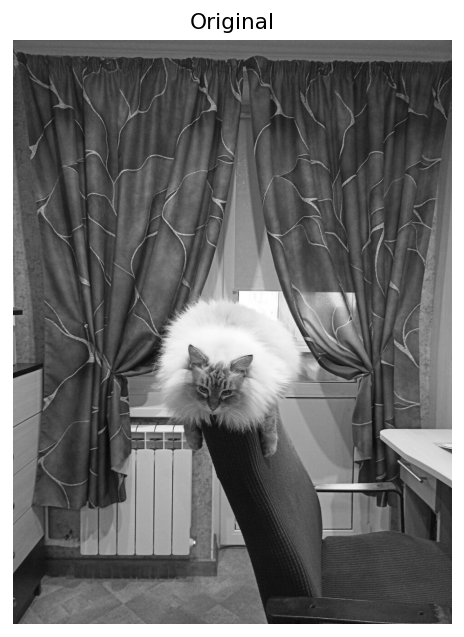

(1280, 960)


In [6]:
img = imread(r'data/kiss.jpg')
img = img.mean(axis=2)

paint([img], ['Original'])
print(img.shape)

In [7]:
n1 = 5
m1 = 4
k = 30
kron_img = compress_kron(img, n1, m1)
svd_img = compress_svd(img, k)
sim_img = compress_simple(img, n1, m1)

kron_params = n1 * m1 + img.shape[0] * img.shape[1] // n1 // m1
svd_params = k * (img.shape[0] + img.shape[1])

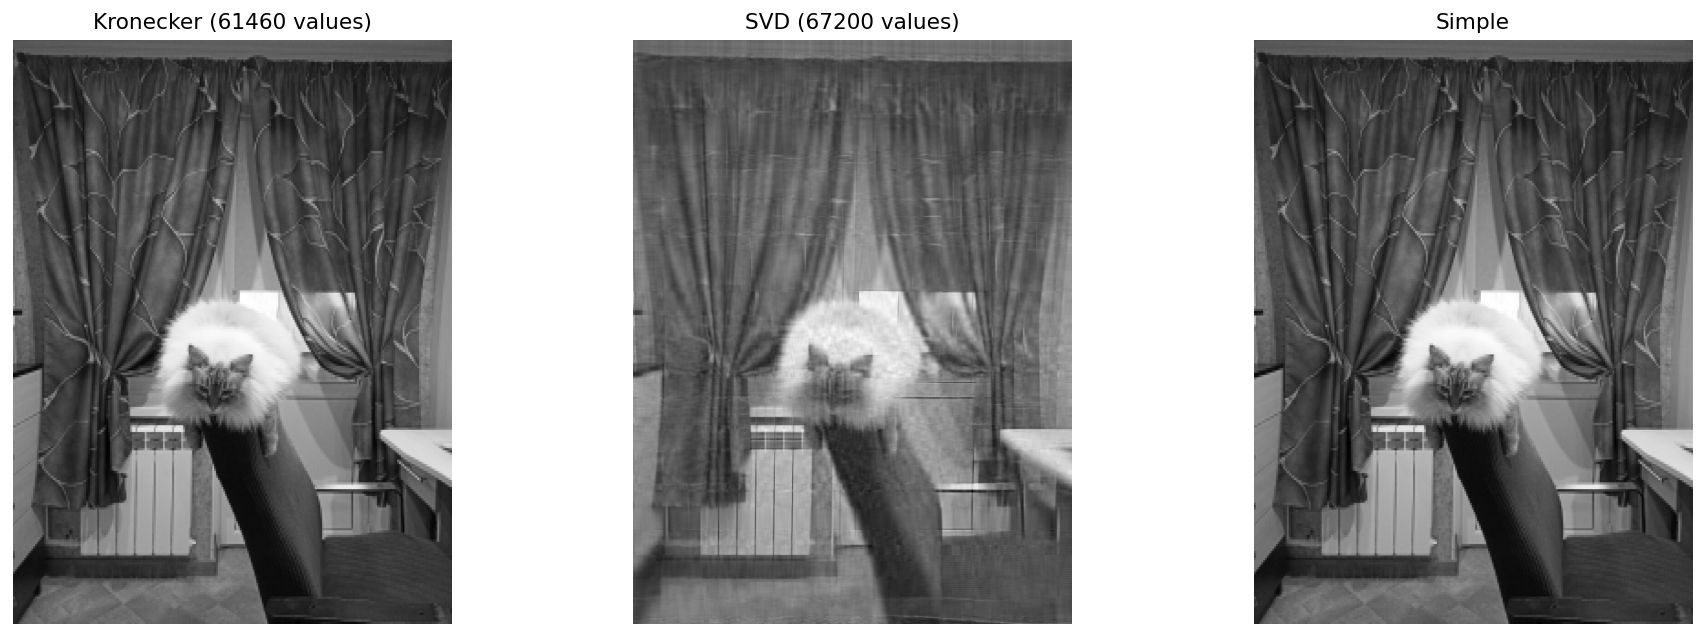

In [8]:
paint([kron_img, svd_img, sim_img], [f'Kronecker ({kron_params} values)', f'SVD ({svd_params} values)', 'Simple'])

In [9]:
print(scipy.linalg.norm(img - kron_img))
print(scipy.linalg.norm(img - svd_img))
print(scipy.linalg.norm(img - sim_img))

12997.767326219047
14184.802549862981
13000.623620725963


Первая и третья картинки очень похожи. Посмотрим на матрицы

In [10]:
print('Разница между Kronecker и Simple ', scipy.linalg.norm(sim_img - kron_img))
print(PSNR(img, kron_img))
print(PSNR(img, svd_img))
print(PSNR(img, sim_img))

Разница между Kronecker и Simple  272.89364025147876
26.748240468151053
25.98914973824108
26.746331930117965


## Example 2


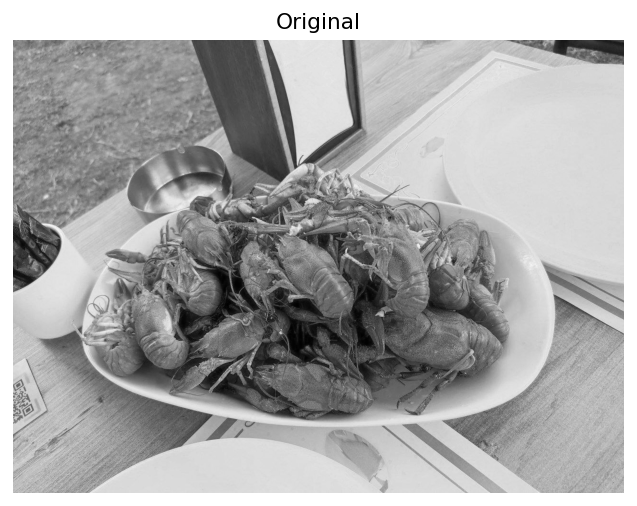

(950, 1280)


In [11]:
img = imread(r'data/crab.jpg')
img = img.mean(axis=2)

paint([img], ['Original'])
print(img.shape)

In [12]:
n1 = 10
m1 = 10
k = 80

kron_img = compress_kron(img, n1, m1)
svd_img = compress_svd(img, k)
sim_img = compress_simple(img, n1, m1)

kron_params = n1 * m1 + img.shape[0] * img.shape[1] // n1 // m1
svd_params = k * (img.shape[0] + img.shape[1])

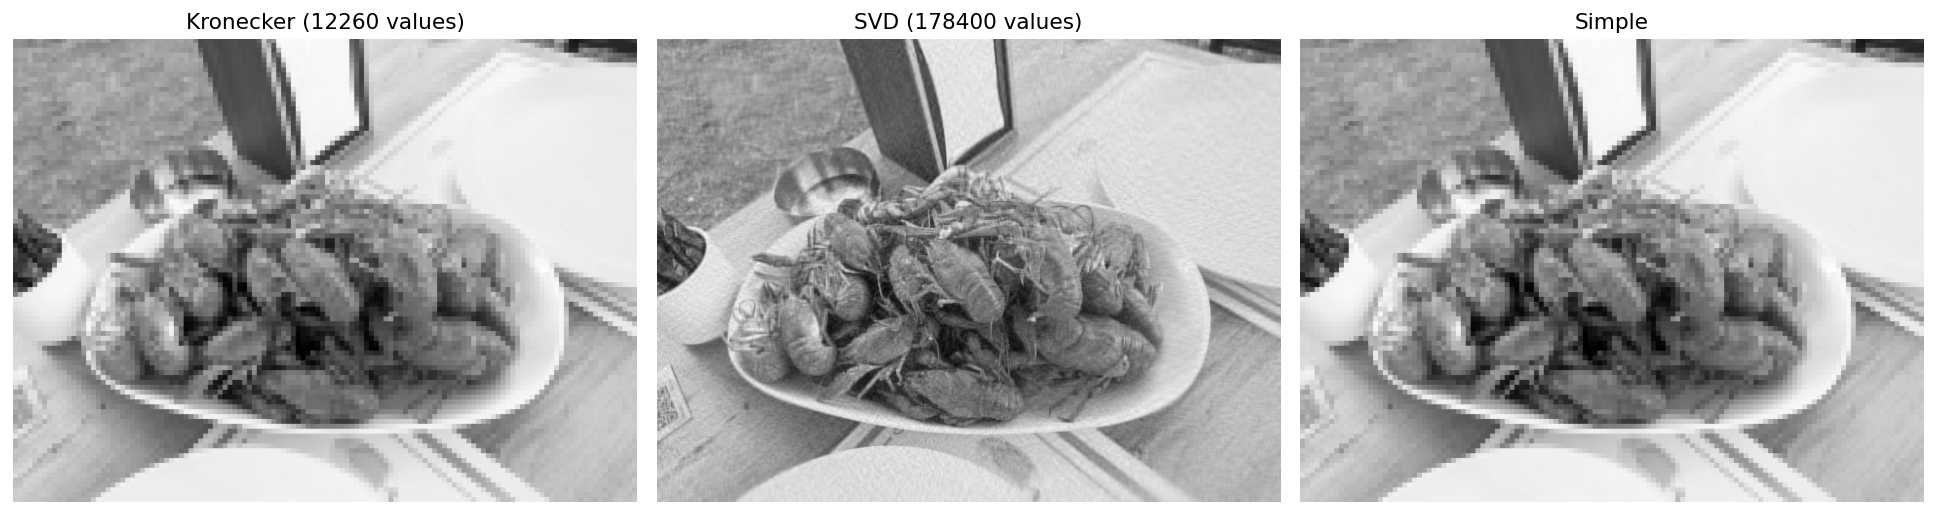

In [13]:
paint([kron_img, svd_img, sim_img], [f'Kronecker ({kron_params} values)', f'SVD ({svd_params} values)', 'Simple'])

In [14]:
print(scipy.linalg.norm(img - kron_img))
print(scipy.linalg.norm(img - svd_img))
print(scipy.linalg.norm(img - sim_img))

19590.23614697909
13068.183161398574
19593.726976906542


In [15]:
print('Разница между Kronecker и Simple ', scipy.linalg.norm(sim_img - kron_img))
print(PSNR(img, kron_img))
print(PSNR(img, sim_img))

Разница между Kronecker и Simple  370.40493247639716
23.139345935025656
23.137798313950185
